# XGBoost Parameter Tuning for Otto Dataset

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

In [2]:
import sys
sys.path.append('/mnt/wc/xgboost/python-package')
sys.path

['',
 '/mnt/wc/anaconda3/envs/fastai/lib/python36.zip',
 '/mnt/wc/anaconda3/envs/fastai/lib/python3.6',
 '/mnt/wc/anaconda3/envs/fastai/lib/python3.6/lib-dynload',
 '/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages',
 '/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions',
 '/root/.ipython',
 '/mnt/wc/xgboost/python-package']

首先 import 必要的模块

In [3]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [7]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"Otto_train.csv")
train.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

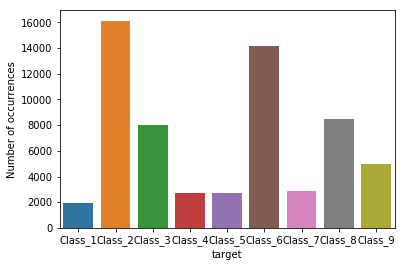

In [6]:
sns.countplot(train.target);
pyplot.xlabel('target');
pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [8]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [9]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

默认参数，此时学习率为0.1，比较大，观察弱分类数目的大致范围
（采用默认参数配置，看看模型是过拟合还是欠拟合）

In [10]:
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=None, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = 9
        
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        
        n_estimators = cvresult.shape[0]
        alg.set_params(n_estimators = n_estimators)
        
        print(cvresult)
        #result = pd.DataFrame(cvresult)   #cv缺省返回结果为DataFrame
        #result.to_csv('my_preds.csv', index_label = 'n_estimators')
        cvresult.to_csv('my_preds_4_1.csv', index_label = 'n_estimators')
        
        # plot
        test_means = cvresult['test-mlogloss-mean']
        test_stds = cvresult['test-mlogloss-std'] 
        
        train_means = cvresult['train-mlogloss-mean']
        train_stds = cvresult['train-mlogloss-std'] 

        x_axis = range(0, n_estimators)
        pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
        pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
        pyplot.title("XGBoost n_estimators vs Log Loss")
        pyplot.xlabel( 'n_estimators' )
        pyplot.ylabel( 'Log Loss' )
        pyplot.savefig( 'n_estimators.png' )
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    train_predprob = alg.predict_proba(X_train)
    logloss = log_loss(y_train, train_predprob)

        
    #Print model report:
    print ("logloss of train :" )
    print (logloss)

In [12]:
#params = {"objective": "multi:softprob", "eval_metric":"mlogloss", "num_class": 9}

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=1, # 最小样本权重和
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        n_jobs= -1)
#modelfit(xgb1, X_train, y_train, cv_folds = kfold)

In [14]:
xgb1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='multi:softprob',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=3, silent=True,
       subsample=0.3, tree_method='gpu_hist')

     test-mlogloss-mean  test-mlogloss-std  train-mlogloss-mean  \
0              1.992057           0.000982             1.989681   
1              1.840765           0.005431             1.836559   
2              1.721532           0.005217             1.716171   
3              1.619117           0.006094             1.612269   
4              1.531516           0.005871             1.523574   
5              1.453727           0.005600             1.444735   
6              1.386200           0.005021             1.376153   
7              1.328852           0.004276             1.317734   
8              1.275834           0.005251             1.263795   
9              1.228817           0.003097             1.215455   
10             1.186252           0.004695             1.171991   
11             1.147535           0.004955             1.132357   
12             1.113359           0.006880             1.097195   
13             1.079685           0.006841             1.06258

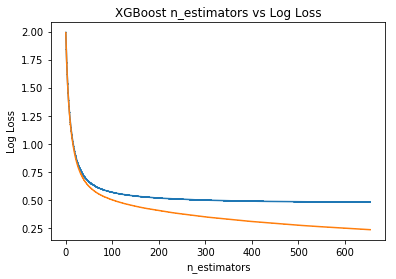

In [15]:
modelfit(xgb1, X_train, y_train, cv_folds = kfold)

In [18]:
xgb1.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.7,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 656,
 'n_jobs': -1,
 'nthread': None,
 'objective': 'multi:softprob',
 'predictor': 'gpu_predictor',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 3,
 'silent': True,
 'subsample': 0.3,
 'tree_method': 'gpu_hist'}

/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


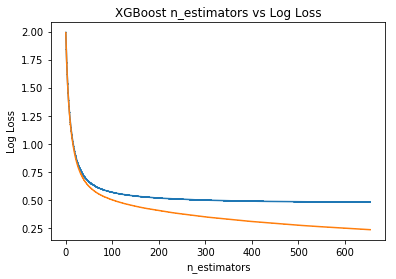

In [16]:
cvresult = pd.DataFrame.from_csv('my_preds_4_1.csv')
        
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])
        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators4_1.png' )

pyplot.show()

/mnt/wc/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


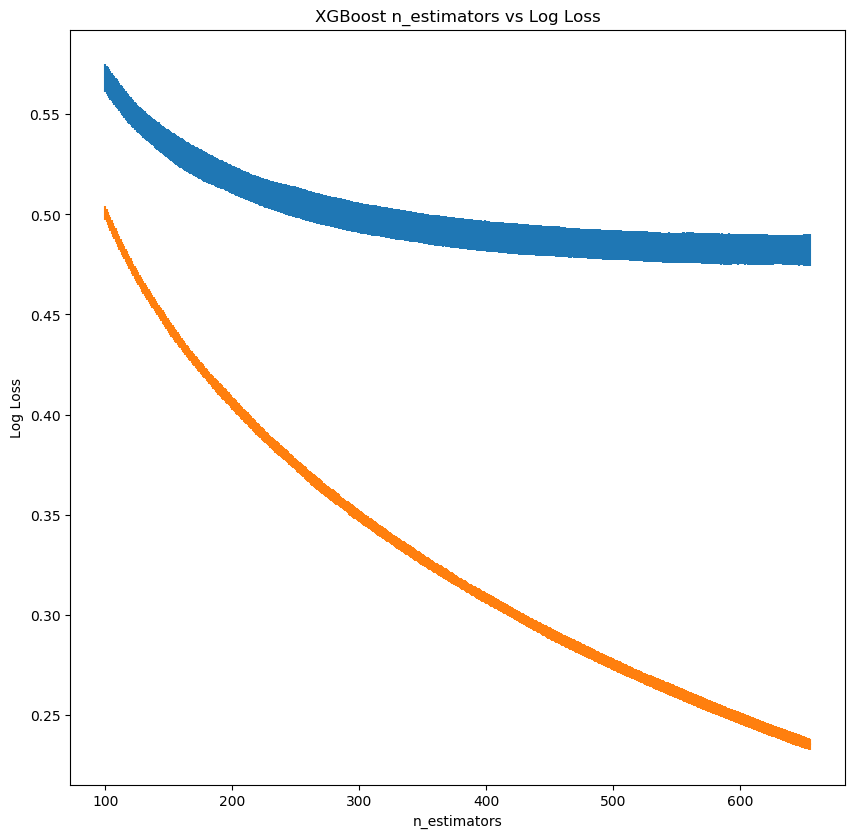

In [17]:
cvresult = pd.DataFrame.from_csv('my_preds_4_1.csv')

cvresult = cvresult.iloc[100:]
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(100,cvresult.shape[0]+100)
        
fig = pyplot.figure(figsize=(10, 10), dpi=100)
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'n_estimators_detail.png' )

pyplot.show()